In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import gc
from scipy import signal
from sympy import fft
from scipy import stats

# !pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
# import fastbook
# fastbook.setup_book()
# !pip install wwf
# from wwf.tabular.export import *
from google.colab import drive
drive.mount('/content/drive')
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
# from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
# from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

# pd.options.display.max_rows = 20
# pd.options.display.max_columns = 8

Mounted at /content/drive
     |████████████████████████████████| 204kB 3.9MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 


In [2]:
# removed atributes
# remove = ['arCoeff', 'correlation', 'bandsEnergy', 'angle','entropy','sma',]
train_df = pd.read_csv("/content/drive/MyDrive/UCI HAR Dataset/train.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/UCI HAR Dataset/test.csv")
data = pd.concat([train_df,valid_df])
data.reset_index(inplace=True)
dep_var = data['Activity']
train_y = train_df['Activity']
valid_y = valid_df['Activity']
data.drop(['subject','Activity'],axis=1,inplace=True)
train_df.drop(['subject','Activity'],axis=1,inplace=True)
valid_df.drop(['subject','Activity'],axis=1,inplace=True)
dic = {}
for c in data.columns:
  dic[c]=c.replace("-","_")
data.rename(columns=dic,inplace=True)
train_df.rename(columns=dic,inplace=True)
valid_df.rename(columns=dic,inplace=True)

In [3]:
tm = ['mean()','std()','mad()','max()','min()','energy()','iqr()']

txyz=['tBodyAcc'
,'tGravityAcc'
,'tBodyAccJerk'
,'tBodyGyro'
,'tBodyGyroJerk']

tmag = [
'tBodyAccMag'
,'tGravityAccMag'
,'tBodyAccJerkMag'
,'tBodyGyroMag'
,'tBodyGyroJerkMag']


In [4]:
#Dealing with txyz
ax=['X','Y','Z']
t_cols= []
for f in txyz:
  for m in tm:
    for i in ax:
      t_cols.append(f+'_'+m+'_'+i)

#Dealing with tmag
for f in tmag:
  for m in tm:
    t_cols.append(f+'_'+m)


In [5]:
clean_cols=t_cols
train_X = train_df[clean_cols]
valid_X = valid_df[clean_cols]
del(train_df)
del(valid_df)
cat_names = []
cont_names = clean_cols
splits = (L(np.arange(7352),use_list=True),
          L(np.arange(7352, 10299), use_list=True))
procs= [Normalize]
data=data[clean_cols]
data.loc[:,'Activity'] = dep_var.values

In [6]:
len(clean_cols)

140

In [100]:
row1 = data[data.Activity=='LAYING'].iloc[100]
row2 = data[data.Activity=='SITTING'].iloc[100]
row3 = data[data.Activity=='STANDING'].iloc[100]
row4 = data[data.Activity=='WALKING'].iloc[100]
row5 = data[data.Activity=='WALKING_DOWNSTAIRS'].iloc[100]
row6 = data[data.Activity=='WALKING_UPSTAIRS'].iloc[100]

row1.drop(["Activity"],inplace=True)
row2.drop(["Activity"],inplace=True)
row3.drop(["Activity"],inplace=True)
row4.drop(["Activity"],inplace=True)
row5.drop(["Activity"],inplace=True)
row6.drop(["Activity"],inplace=True)


#Fastai Neural Net

In [37]:
to = TabularPandas(data, procs, cat_names=cat_names, cont_names=clean_cols, y_names="Activity",splits=splits,y_block = CategoryBlock(),device=torch.device('cpu'))
trn_dl = TabDataLoader(to.train, bs=128,shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=32)
dls = DataLoaders(trn_dl, val_dl)
gc.collect()
def calcHiddenLayer(data, alpha, ip, op, numHiddenLayers):
  return [(len(data.train_ds)//(alpha*(ip+op)))//numHiddenLayers]*numHiddenLayers
learn = tabular_learner(dls, layers=calcHiddenLayer(dls, 3, len(data.columns), 6, 2), metrics=accuracy)

In [38]:
learn.summary()

TabularModel (Input shape: 128 x torch.Size([128, 140]))
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 140           
BatchNorm1d                               280        True      
____________________________________________________________________________
                     128 x 8             
Linear                                    1120       True      
ReLU                                                           
BatchNorm1d                               16         True      
Linear                                    64         True      
ReLU                                                           
BatchNorm1d                               16         True      
____________________________________________________________________________
                     128 x 6             
Linear                                    54         True      
____________________________________________________________________________

Total par

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.12022644281387329)

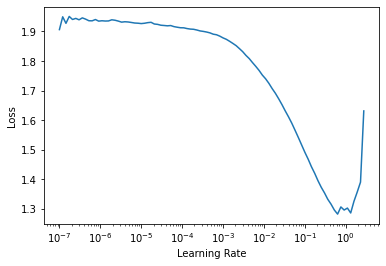

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(12, lr_max=slice(0.06309573650360108,0.12022644281387329))

epoch,train_loss,valid_loss,accuracy,time
0,0.950019,0.660676,0.738378,00:01
1,0.463636,0.807695,0.749237,00:00
2,0.317324,0.333840,0.870716,00:00
3,0.254513,0.610009,0.791313,00:00
4,0.227440,0.320082,0.885307,00:01
5,0.189360,0.269392,0.902273,00:00
6,0.167913,0.807576,0.758738,00:00
7,0.163709,0.640154,0.857482,00:01
8,0.152967,0.244612,0.898541,00:00
9,0.138339,0.223886,0.918561,00:00


In [41]:
learn.show_results()

,tBodyAcc_mean()_X,tBodyAcc_mean()_Y,tBodyAcc_mean()_Z,tBodyAcc_std()_X,tBodyAcc_std()_Y,tBodyAcc_std()_Z,tBodyAcc_mad()_X,tBodyAcc_mad()_Y,tBodyAcc_mad()_Z,tBodyAcc_max()_X,tBodyAcc_max()_Y,tBodyAcc_max()_Z,tBodyAcc_min()_X,tBodyAcc_min()_Y,tBodyAcc_min()_Z,tBodyAcc_energy()_X,tBodyAcc_energy()_Y,tBodyAcc_energy()_Z,tBodyAcc_iqr()_X,tBodyAcc_iqr()_Y,tBodyAcc_iqr()_Z,tGravityAcc_mean()_X,tGravityAcc_mean()_Y,tGravityAcc_mean()_Z,tGravityAcc_std()_X,tGravityAcc_std()_Y,tGravityAcc_std()_Z,tGravityAcc_mad()_X,tGravityAcc_mad()_Y,tGravityAcc_mad()_Z,tGravityAcc_max()_X,tGravityAcc_max()_Y,tGravityAcc_max()_Z,tGravityAcc_min()_X,tGravityAcc_min()_Y,tGravityAcc_min()_Z,tGravityAcc_energy()_X,tGravityAcc_energy()_Y,tGravityAcc_energy()_Z,tGravityAcc_iqr()_X,tGravityAcc_iqr()_Y,tGravityAcc_iqr()_Z,tBodyAccJerk_mean()_X,tBodyAccJerk_mean()_Y,tBodyAccJerk_mean()_Z,tBodyAccJerk_std()_X,tBodyAccJerk_std()_Y,tBodyAccJerk_std()_Z,tBodyAccJerk_mad()_X,tBodyAccJerk_mad()_Y,tBodyAccJerk_mad()_Z,tBodyAccJerk_max()_X,tBodyAccJerk_max()_Y,tBodyAccJerk_max()_Z,tBodyAccJerk_min()_X,tBodyAccJerk_min()_Y,tBodyAccJerk_min()_Z,tBodyAccJerk_energy()_X,tBodyAccJerk_energy()_Y,tBodyAccJerk_energy()_Z,tBodyAccJerk_iqr()_X,tBodyAccJerk_iqr()_Y,tBodyAccJerk_iqr()_Z,tBodyGyro_mean()_X,tBodyGyro_mean()_Y,tBodyGyro_mean()_Z,tBodyGyro_std()_X,tBodyGyro_std()_Y,tBodyGyro_std()_Z,tBodyGyro_mad()_X,tBodyGyro_mad()_Y,tBodyGyro_mad()_Z,tBodyGyro_max()_X,tBodyGyro_max()_Y,tBodyGyro_max()_Z,tBodyGyro_min()_X,tBodyGyro_min()_Y,tBodyGyro_min()_Z,tBodyGyro_energy()_X,tBodyGyro_energy()_Y,tBodyGyro_energy()_Z,tBodyGyro_iqr()_X,tBodyGyro_iqr()_Y,tBodyGyro_iqr()_Z,tBodyGyroJerk_mean()_X,tBodyGyroJerk_mean()_Y,tBodyGyroJerk_mean()_Z,tBodyGyroJerk_std()_X,tBodyGyroJerk_std()_Y,tBodyGyroJerk_std()_Z,tBodyGyroJerk_mad()_X,tBodyGyroJerk_mad()_Y,tBodyGyroJerk_mad()_Z,tBodyGyroJerk_max()_X,tBodyGyroJerk_max()_Y,tBodyGyroJerk_max()_Z,tBodyGyroJerk_min()_X,tBodyGyroJerk_min()_Y,tBodyGyroJerk_min()_Z,tBodyGyroJerk_energy()_X,tBodyGyroJerk_energy()_Y,tBodyGyroJerk_energy()_Z,tBodyGyroJerk_iqr()_X,tBodyGyroJerk_iqr()_Y,tBodyGyroJerk_iqr()_Z,tBodyAccMag_mean(),tBodyAccMag_std(),tBodyAccMag_mad(),tBodyAccMag_max(),tBodyAccMag_min(),tBodyAccMag_energy(),tBodyAccMag_iqr(),tGravityAccMag_mean(),tGravityAccMag_std(),tGravityAccMag_mad(),tGravityAccMag_max(),tGravityAccMag_min(),tGravityAccMag_energy(),tGravityAccMag_iqr(),tBodyAccJerkMag_mean(),tBodyAccJerkMag_std(),tBodyAccJerkMag_mad(),tBodyAccJerkMag_max(),tBodyAccJerkMag_min(),tBodyAccJerkMag_energy(),tBodyAccJerkMag_iqr(),tBodyGyroMag_mean(),tBodyGyroMag_std(),tBodyGyroMag_mad(),tBodyGyroMag_max(),tBodyGyroMag_min(),tBodyGyroMag_energy(),tBodyGyroMag_iqr(),tBodyGyroJerkMag_mean(),tBodyGyroJerkMag_std(),tBodyGyroJerkMag_mad(),tBodyGyroJerkMag_max(),tBodyGyroJerkMag_min(),tBodyGyroJerkMag_energy(),tBodyGyroJerkMag_iqr(),Activity,Activity_pred
0,-0.004209,-0.099643,0.120368,-0.866125,-0.928452,-0.883030,-0.858981,-0.927033,-0.883874,-0.857038,-0.943296,-0.861143,0.891596,0.828477,0.803244,-0.693032,-0.774962,-0.691594,-0.837114,-0.900763,-0.879273,0.407910,-1.158915,-0.077654,-0.379044,-0.426713,-0.456783,-0.389795,-0.438173,-0.457249,0.386393,-1.198321,-0.100399,0.420008,-1.123895,-0.036951,0.338422,0.097407,-0.568590,-0.424844,-0.446107,-0.455938,-0.029629,-0.076061,0.033131,-0.849567,-0.861085,-0.796101,-0.846440,-0.860856,-0.793040,-0.797499,-0.820047,-0.751666,0.851861,0.825851,0.794870,-0.681675,-0.715895,-0.566590,-0.830619,-0.847676,-0.779043,-0.047078,0.071457,0.060224,-0.786757,-0.819251,-0.850317,-0.780593,-0.817700,-0.842022,-0.774446,-0.750365,-0.805465,0.721729,0.783584,0.842923,-0.672667,-0.600731,-0.648012,-0.771042,-0.804949,-0.814894,0.162117,-0.075312,-0.038625,-0.818781,-0.722985,-0.810243,-0.811675,-0.730790,-0.810666,-0.798776,-0.664634,-0.799503,0.807360,0.689465,0.760415,-0.606053,-0.439575,-0.585812,-0.800132,-0.735902,-0.805694,-0.923047,-0.906590,-0.907915,-0.892808,-0.778916,-0.783610,-0.901490,-0.923047,-0.9065

To get prediction on a new dataframe, you can use the `test_dl` method of the `DataLoaders`. That dataframe does not need to have the dependent variable in its column.

Then `Learner.get_preds` will give you the predictions:

> Note: Since machine learning models can't magically understand categories it was never trained on, the data should reflect this. If there are different missing values in your test data you should address this before training

# `Random Forest` Model Interpretation

As mentioned earlier, `TabularPandas` is a powerful and easy preprocessing tool for tabular data. Integration with libraries such as Random Forests and XGBoost requires only one extra step, that the `.dataloaders` call did for us. Let's look at our `to` again. It's values are stored in a `DataFrame` like object, where we can extract the `cats`, `conts,` `xs` and `ys` if we want to:

A TabularPandas behaves a lot like a fastai Datasets object, including providing train and valid attributes

In [ ]:
#Now we will make use of special Fastai pd.Dataframe wrapper called TabularPandas
tor = TabularPandas(data, procs=[Normalize], cat_names=cat_names, cont_names=cont_names, y_names='Activity', splits=splits)

In [ ]:
xs,y = tor.train.xs,tor.train.y
valid_xs,valid_y = tor.valid.xs,tor.valid.y
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
def rf(xs, y, n_estimators=120, max_samples=0.8,min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples,min_samples_leaf=min_samples_leaf,bootstrap=True, oob_score=True).fit(xs, y)

In [ ]:
#Fitting the Model
m = rf(xs, y);

In [ ]:
print("Training Error = ",m_rmse(m, xs, y))
print("Validation Error = ",m_rmse(m, valid_xs, valid_y)) 
print("OOB Error = ",1-m.oob_score_)

Training Error =  0.124523
Validation Error =  0.600588
OOB Error =  0.03563656147986938


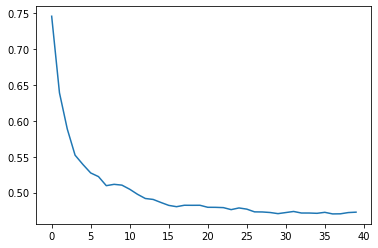

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

> How confident are we in our predictions using a particular row of data?
> For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
> Which columns are the strongest predictors, which can we ignore?
> Which columns are effectively redundant with each other, for purposes of prediction?
> How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

## Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10] #10 Most Important Features

,cols,imp
33,tGravityAcc_min()_X,0.085714
31,tGravityAcc_max()_Y,0.053245
36,tGravityAcc_energy()_X,0.049473
21,tGravityAcc_mean()_X,0.049341
34,tGravityAcc_min()_Y,0.044329
22,tGravityAcc_mean()_Y,0.043795
3,tBodyAcc_std()_X,0.038936
30,tGravityAcc_max()_X,0.038754
9,tBodyAcc_max()_X,0.034952
37,tGravityAcc_energy()_Y,0.034318


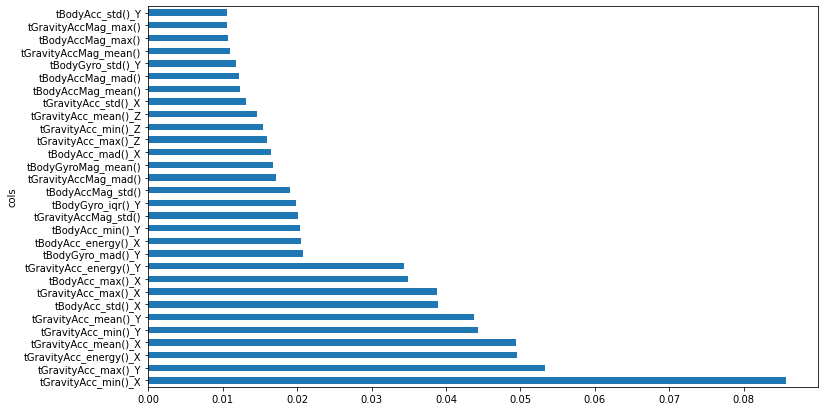

In [ ]:
#Top 30 Most Imporant Features
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

# Ensembling with other Approaches

In [42]:
# Import all machine learning algorithms
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Import other useful subpackage
from sklearn.metrics import accuracy_score

In [43]:
accuracy_scores = np.zeros(4)

# Support Vector Classifier
clf1= SVC().fit(train_X, train_y)
prediction1 = clf1.predict(valid_X)
accuracy_scores[0] = accuracy_score(valid_y, prediction1)*100
print('Support Vector Classifier accuracy: {}%'.format(accuracy_scores[0]))

# Logistic Regression
clf2 = LogisticRegression().fit(train_X, train_y)
prediction2 = clf2.predict(valid_X)
accuracy_scores[1] = accuracy_score(valid_y, prediction2)*100
print('Logistic Regression accuracy: {}%'.format(accuracy_scores[1]))

# K Nearest Neighbors
clf3 = KNeighborsClassifier().fit(train_X, train_y)
prediction3 = clf3.predict(valid_X)
accuracy_scores[2] = accuracy_score(valid_y, prediction3)*100
print('K Nearest Neighbors Classifier accuracy: {}%'.format(accuracy_scores[2]))


# Random Forest
clf4 = RandomForestClassifier().fit(train_X, train_y)
prediction4 = clf4.predict(valid_X)
accuracy_scores[3] = accuracy_score(valid_y, prediction4)*100
print('Random Forest Classifier accuracy: {}%'.format(accuracy_scores[3]))


Support Vector Classifier accuracy: 91.72039362063114%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression accuracy: 92.26331862911435%
K Nearest Neighbors Classifier accuracy: 88.73430607397353%
Random Forest Classifier accuracy: 90.29521547336275%


Text(0.5, 1.0, 'Accuracy of various algorithms')

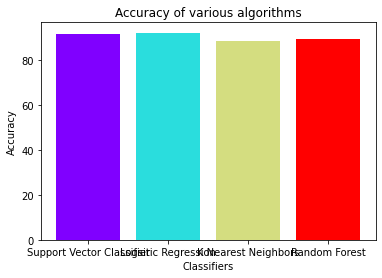

In [ ]:
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 4))
labels = ['Support Vector Classifier', 'Logsitic Regression', 'K Nearest Neighbors', 'Random Forest']
plt.bar(labels,
        accuracy_scores,
        color = colors)
plt.rcParams["figure.figsize"] = (20, 8)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy of various algorithms')


#Noise Removal and Filtering 


In [44]:
sample_rate=50

#Input Signal = x
def butter_lowpass(cutoff, nyq_freq, order=3):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data,padlen=0)
    return y

#Removing the Noise from Signal using Cutoff Freq. = 20Hz and Low Pass Butterworth Filter of Order 3
def removeNoise(x):
  x = butter_lowpass_filter(x, 20, sample_rate/2,order=3)
  return x
 
#filtering the signal sperate tAccXYZ -> tBodyXYZ + tGravityXYZ
def sep(x):
  x = signal.medfilt(x, kernel_size=3) #Using Median filter to remove extra Noise
  tBodyAcc_ = butter_lowpass_filter(x, 0.3, sample_rate/2,order=4)
  tGravityAcc_ = np.array(x)-np.array(tBodyAcc_)
  return tBodyAcc_,tGravityAcc_

# Visualize
# plt.figure(figsize=(11, 9))
# plt.plot(x, color='red', label="Original signal, {} samples".format(signal_lenght))
# plt.plot(tBodyAcc_, color='blue', label="Filtered low-pass with cutoff frequency of {} Hz".format(cutoff_frequency))
# plt.plot(tGravityAcc_, color='gray', label="What has been removed")
# plt.title("Signal and its filtering")
# plt.xlabel('Time (1/50th sec. per tick)')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()

In [69]:
df = pd.DataFrame(np.nan, index=[0], columns=clean_cols)

In [60]:
def calc_mean(total_signals):
    cols= []
    for f in clean_cols:
      if "_mean()" in f:
        cols.append(f)
    cols_strip = [f.replace("_mean()","") for f in cols]
    for i in range(len(cols)):
      if cols_strip[i] in total_signals:
        df.at[0, cols[i]]=np.mean(np.array(total_signals[cols_strip[i]]))
    


def calc_std(total_signals):
  cols= []
  for f in clean_cols:
    if "_std()" in f:
      cols.append(f)
  cols_strip = [f.replace("_std()","") for f in cols]
  for i in range(len(cols)):
    if cols_strip[i] in total_signals:
      df.at[0, cols[i]]=np.std(np.array(total_signals[cols_strip[i]]).astype(np.float32))
  

def calc_mad(total_signals):
  cols= []
  for f in clean_cols:
    if "_mad()" in f:
      cols.append(f)
  cols_strip = [f.replace("_mad()","") for f in cols]
  for i in range(len(cols)):
    if cols_strip[i] in total_signals:
      df.at[0, cols[i]]=stats.median_absolute_deviation(np.array(total_signals[cols_strip[i]]))
  

def calc_max(total_signals):
   cols= []
   for f in clean_cols:
     if "_max()" in f:
       cols.append(f)
   cols_strip = [f.replace("_max()","") for f in cols]
   for i in range(len(cols)):
     if cols_strip[i] in total_signals:
       df.at[0, cols[i]]=np.max(np.array(total_signals[cols_strip[i]]))
   

def calc_min(total_signals):
  cols= []
  for f in clean_cols:
    if "_min()" in f:
      cols.append(f)
  cols_strip = [f.replace("_min()","") for f in cols]
  for i in range(len(cols)):
    if cols_strip[i] in total_signals:
      df.at[0, cols[i]]=np.min(np.array(total_signals[cols_strip[i]]))
  

def calc_energy(total_signals):
  cols= []
  for f in clean_cols:
    if "_energy()" in f:
      cols.append(f)
  cols_strip = [f.replace("_energy()","") for f in cols]
  for i in range(len(cols)):
    if cols_strip[i] in total_signals:
      df.at[0, cols[i]]=np.sum(np.array(total_signals[cols_strip[i]])**2)/len(np.array(total_signals[cols_strip[i]]))
  


def calc_iqr(total_signals):
  cols= []
  for f in clean_cols:
    if "_iqr()" in f:
      cols.append(f)
  cols_strip = [f.replace("_iqr()","") for f in cols]
  for i in range(len(cols)):
    if cols_strip[i] in total_signals:
      df.at[0, cols[i]]=stats.iqr(np.array(total_signals[cols_strip[i]]),axis=0)
  
    

# def calc_MaxInds(f_signals):
#   cols= []
#   for f in clean_cols:
#     if "_MaxInds()" in f:
#       cols.append(f)
#   cols_strip = [f.replace("_MaxInds()","") for f in cols]
#   for i in range(len(cols)):
#     if cols_strip[i] in f_signals:
#       df.at[0, cols[i]]=np.array(f_signals[cols[i]]).argmax(axis=0)
  

# def calc_meanFreq(f_signals):
#   cols= []
#   for f in clean_cols:
#     if "_meanFreq()" in f:
#       cols.append(f)
#   cols_strip = [f.replace("_meanFreq()","") for f in cols]
#   for i in range(len(cols)):
#     if cols_strip[i] in f_signals:
#       weights = np.array([x for x in range(len(np.array(f_signals[cols_strip[i]])))])
#       weights += 1
#       df.at[0, cols[i]]=np.mean(np.array(f_signals[cols_strip[i]]).weights,axis=0)
  


def calc_skewness(f_signals):
  cols= []
  for f in clean_cols:
    if "_skewness()" in f:
      cols.append(f)
  cols_strip = [f.replace("_skewness()","") for f in cols]
  for i in range(len(cols)):
    if cols_strip[i] in f_signals:
      df.at[0, cols[i]]=stats.skew(np.array(f_signals[cols_strip[i]]))
  


def calc_kurtosis(f_signals):
  cols= []
  for f in clean_cols:
    if "_kurtosis()" in f:
      cols.append(f)
  cols_strip = [f.replace("-kurtosis()","") for f in cols]
  for i in range(len(cols)):
    if cols_strip[i] in f_signals:
      df.at[0, cols[i]]=stats.kurtosis(np.array(f_signals[cols_strip[i]]))
  

In [61]:
# the body linear acceleration and angular velocity were derived in time to obtain Jerk signals (tBodyAccJerk_XYZ and tBodyGyroJerk_XYZ). 
def jerk_norm_fft(df,tBodyAcc_X,tBodyAcc_Y,tBodyAcc_Z,tGravityAcc_X,tGravityAcc_Y,tGravityAcc_Z,tGyro_X,tGyro_Y,tGyro_Z):
  
  #jerk
  tBodyAccJerk_X =  np.append(np.array([2*tBodyAcc_X[0]-tBodyAcc_X[1]]),tBodyAcc_X[1:]- tBodyAcc_X[:-1])/0.02
  tBodyAccJerk_Y =  np.append(np.array([2*tBodyAcc_Y[0]-tBodyAcc_Y[1]]),tBodyAcc_Y[1:]- tBodyAcc_Y[:-1])/0.02
  tBodyAccJerk_Z =  np.append(np.array([2*tBodyAcc_Z[0]-tBodyAcc_Z[1]]),tBodyAcc_Z[1:]- tBodyAcc_Z[:-1])/0.02
  tBodyGyroJerk_X = np.append(np.array([2*tGyro_X[0]-tGyro_X[1]]),tGyro_X[1:]-tGyro_X[:-1])/0.02
  tBodyGyroJerk_Y = np.append(np.array([2*tGyro_Y[0]-tGyro_Y[1]]),tGyro_Y[1:]-tGyro_Y[:-1])/0.02
  tBodyGyroJerk_Z = np.append(np.array([2*tGyro_Z[0]-tGyro_Z[1]]),tGyro_Z[1:]-tGyro_Z[:-1])/0.02


  #norm
  tBodyAccMag     =np.sqrt(tBodyAcc_X**2+tBodyAcc_Y**2+tBodyAcc_Z**2)
  tGravityAccMag  =np.sqrt(tGravityAcc_X**2+tGravityAcc_Y**2+tGravityAcc_Z**2)
  tBodyAccJerkMag =np.sqrt(tBodyAccJerk_X**2+tBodyAccJerk_Y**2+tBodyAccJerk_Z**2)
  tBodyGyroMag    =np.sqrt(tGyro_X**2+tGyro_Y**2+tGyro_Z**2)
  tBodyGyroJerkMag=np.sqrt(tBodyGyroJerk_X**2+tBodyGyroJerk_Y**2+tBodyGyroJerk_Z**2)

  t_signals = { 'tBodyAcc_X':tBodyAcc_X
               ,'tBodyAcc_Y':tBodyAcc_Y
               ,'tBodyAcc_Z':tBodyAcc_Z
               ,'tGravityAcc_X':tGravityAcc_X
               ,'tGravityAcc_Y':tGravityAcc_Y
               ,'tGravityAcc_Z':tGravityAcc_Z
               ,'tBodyGyro_X':tGyro_X
               ,'tBodyGyro_Y':tGyro_Y
               ,'tBodyGyro_Z':tGyro_Z
               ,'tBodyAccJerk_X':tBodyAccJerk_X
               ,'tBodyAccJerk_Y':tBodyAccJerk_Y
               ,'tBodyAccJerk_Z':tBodyAccJerk_Z
               ,'tBodyGyroJerk_X':tBodyGyroJerk_X
               ,'tBodyGyroJerk_Y':tBodyGyroJerk_Y
               ,'tBodyGyroJerk_Z':tBodyGyroJerk_Z
               ,'tBodyAccMag':tBodyAccMag               
               ,'tGravityAccMag':tGravityAccMag
               ,'tBodyAccJerkMag':tBodyAccJerkMag
               ,'tBodyGyroMag':tBodyGyroMag
               ,'tBodyGyroJerkMag': tBodyGyroJerkMag
  }
               
  return t_signals


In [62]:
def initiate(x):

  tAcc_X = x[:,0]
  tAcc_Y =x[:,1]
  tAcc_Z =x[:,2]
  tGyro_X =x[:,3]
  tGyro_Y =x[:,4]
  tGyro_Z =x[:,5]

  #Noise Removal
  tAcc_X = removeNoise(tAcc_X)
  tAcc_Y = removeNoise(tAcc_Y)
  tAcc_Z = removeNoise(tAcc_Z)
  tGyro_X = removeNoise(tGyro_X)
  tGyro_Y = removeNoise(tGyro_Y)
  tGyro_Z = removeNoise(tGyro_Z)

  #Accleration Signal Seperation into Body+Gravity 
  tBodyAcc_X,tGravityAcc_X = sep(tAcc_X)
  tBodyAcc_Y,tGravityAcc_Y = sep(tAcc_Y)
  tBodyAcc_Z,tGravityAcc_Z = sep(tAcc_Z)

  t_signals=jerk_norm_fft(df,tBodyAcc_X,tBodyAcc_Y,tBodyAcc_Z,tGravityAcc_X,tGravityAcc_Y,tGravityAcc_Z,tGyro_X,tGyro_Y,tGyro_Z)
  
  return t_signals

def preprocess(x):

  total_signals = initiate(x)
  calc_mean(total_signals)
  calc_std(total_signals)
  calc_mad(total_signals)
  calc_max(total_signals)
  calc_min(total_signals)
  calc_energy(total_signals)
  calc_iqr(total_signals)
  # calc_maxInds(f_signals_names,f_signals)
  # calc_meanFreq(f_signals_names,f_signals)
  # calc_skewness(f_signals)
  # calc_kurtosis(f_signals)
  
  


In [98]:
def prediction(x):
  x = x-x.mean(axis=0)/x.std(axis=0) #Normalization
  preprocess(x) #Preprocessing
  df.iloc[0]=row5
  row = np.expand_dims(df.iloc[0].values, axis=0)
  to = learn.dls.train_ds.new(df)
  to.process()
  dl = TabDataLoader(to)
  pds = learn.get_preds(dl=dl)
  nn_pred = learn.dls.vocab[pds[0].argmax()]

  #print predictions
  print("SVM Prediction : ", clf1.predict(row))
  print("Logistic Regression Prediction : ", clf2.predict(row))
  print("KNN Classifer Prediction: ", clf3.predict(row))
  print("Random Forest Prediction : ", clf4.predict(row))
  print("Tabular Neural Net Prediction : ", nn_pred)
  


In [57]:
x1 = np.array([
[-1.211,1.768,8.564,-2.000,0.000,-3.000],
[-1.213,1.706,8.576,-3.000,1.000,-2.000],
[-1.158,1.716,8.564,0.000,2.000,-1.000],
[-1.189,1.706,8.463,2.000,0.000,0.000],
[-1.177,1.785,8.485,-2.000,0.000,-2.000],
[-1.158,1.711,8.631,5.000,-2.000,-2.000],
[-1.175,1.680,8.497,5.000,0.000,-1.000],
[-1.213,1.687,8.542,2.000,2.000,0.000],
[-1.259,1.716,8.492,4.000,1.000,0.000],
[-1.235,1.771,8.509,0.000,4.000,-4.000],
[-1.172,1.766,8.530,6.000,1.000,-4.000],
[-1.242,1.797,8.533,7.000,-2.000,-2.000],
[-1.158,1.718,8.511,1.000,2.000,1.000],
[-1.244,1.718,8.473,2.000,-1.000,-1.000],
[-1.204,1.737,8.480,0.000,-3.000,1.000],
[-1.206,1.766,8.571,-4.000,-2.000,-4.000],
[-1.199,1.665,8.480,-8.000,-2.000,2.000],
[-1.125,1.701,8.530,2.000,1.000,-3.000],
[-1.268,1.742,8.545,10.000,-3.000,-6.000],
[-1.204,1.723,8.583,1.000,1.000,0.000],
[-1.247,1.706,8.538,1.000,-2.000,-1.000],
[-1.196,1.737,8.504,5.000,-4.000,1.000],
[-1.168,1.711,8.629,-2.000,0.000,-2.000],
[-1.189,1.773,8.396,-5.000,2.000,-1.000],
[-1.110,1.718,8.564,-2.000,-2.000,-4.000],
[-1.182,1.687,8.554,0.000,-4.000,-8.000],
[-1.172,1.747,8.528,3.000,-2.000,-4.000],
[-1.194,1.718,8.439,0.000,-2.000,1.000],
[-1.206,1.725,8.509,2.000,1.000,-3.000],
[-1.144,1.708,8.540,-4.000,1.000,-3.000],
[-1.196,1.744,8.480,-3.000,1.000,1.000],
[-1.218,1.737,8.506,-1.000,-1.000,-4.000],
[-1.199,1.752,8.581,-4.000,1.000,-5.000],
[-1.196,1.775,8.595,-1.000,1.000,-1.000],
[-1.259,1.692,8.497,1.000,2.000,-6.000],
[-1.141,1.639,8.416,2.000,4.000,-2.000],
[-1.208,1.634,8.442,2.000,3.000,-7.000],
[-1.184,1.711,8.559,10.000,4.000,-9.000],
[-1.268,1.716,8.480,16.000,7.000,-5.000],
[-1.237,1.759,8.530,15.000,2.000,-3.000],
[-1.151,1.766,8.609,6.000,6.000,-5.000],
[-1.175,1.790,8.550,-7.000,5.000,1.000],
[-1.175,1.728,8.554,-7.000,6.000,2.000],
[-1.158,1.673,8.528,-3.000,4.000,-4.000],
[-1.244,1.675,8.585,9.000,4.000,-8.000],
[-1.204,1.711,8.595,10.000,2.000,-12.000],
[-1.201,1.708,8.509,12.000,2.000,-8.000],
[-1.201,1.718,8.518,10.000,0.000,-5.000],
[-1.244,1.811,8.502,11.000,0.000,1.000],
[-1.208,1.783,8.454,-8.000,0.000,5.000],
[-1.223,1.694,8.554,-15.000,0.000,7.000],
[-1.146,1.665,8.547,-2.000,0.000,2.000],
[-1.172,1.718,8.557,4.000,-2.000,-2.000],
[-1.170,1.701,8.578,3.000,-2.000,-3.000],
[-1.244,1.720,8.473,3.000,-4.000,-9.000],
[-1.170,1.752,8.471,3.000,-4.000,-8.000],
[-1.242,1.850,8.430,-3.000,-1.000,-5.000],
[-1.177,1.735,8.533,-3.000,0.000,1.000],
[-1.223,1.716,8.614,-5.000,0.000,1.000],
[-1.302,1.718,8.511,-7.000,-3.000,1.000],
[-1.211,1.699,8.490,-4.000,-4.000,-1.000],
[-1.218,1.692,8.569,1.000,-2.000,-2.000],
[-1.187,1.692,8.466,2.000,-1.000,-1.000],
[-1.254,1.723,8.576,2.000,-2.000,-5.000],
[-1.208,1.752,8.516,4.000,-1.000,-3.000],
[-1.182,1.735,8.480,0.000,-1.000,-2.000],
[-1.235,1.680,8.535,0.000,-1.000,-3.000],
[-1.206,1.752,8.511,6.000,-3.000,-1.000],
[-1.290,1.725,8.475,6.000,-3.000,-3.000],
[-1.228,1.768,8.518,5.000,-2.000,1.000],
[-1.180,1.735,8.475,2.000,-2.000,0.000],
[-1.182,1.708,8.432,1.000,-1.000,-3.000],
[-1.239,1.747,8.430,4.000,-1.000,-3.000],
[-1.242,1.756,8.487,-4.000,-2.000,-2.000],
[-1.208,1.766,8.566,0.000,-1.000,-7.000],
[-1.247,1.704,8.550,-1.000,-6.000,-3.000],
[-1.232,1.718,8.552,-3.000,-7.000,-3.000],
[-1.161,1.735,8.468,4.000,-7.000,-1.000],
[-1.196,1.732,8.502,-5.000,-2.000,-2.000],
[-1.204,1.668,8.569,-7.000,0.000,0.000],
[-1.263,1.711,8.487,2.000,-3.000,-3.000],
[-1.151,1.680,8.550,7.000,-2.000,-2.000],
[-1.208,1.716,8.511,0.000,-3.000,-1.000],
[-1.199,1.713,8.538,1.000,1.000,2.000],
[-1.225,1.756,8.523,1.000,-3.000,-3.000],
[-1.230,1.742,8.461,-1.000,-2.000,-5.000],
[-1.249,1.749,8.475,-2.000,-2.000,-3.000],
[-1.189,1.730,8.600,3.000,0.000,-5.000],
[-1.208,1.699,8.497,1.000,0.000,1.000],
[-1.244,1.711,8.514,0.000,0.000,-3.000],
[-1.244,1.754,8.569,7.000,2.000,-5.000],
[-1.228,1.706,8.480,4.000,0.000,-2.000],
[-1.218,1.725,8.487,0.000,-2.000,-3.000],
[-1.168,1.687,8.538,5.000,-2.000,-1.000],
[-1.161,1.732,8.475,2.000,1.000,4.000],
[-1.196,1.689,8.413,-4.000,-1.000,-1.000],
[-1.204,1.725,8.432,4.000,-1.000,-3.000],
[-1.213,1.701,8.499,7.000,-2.000,-3.000],
[-1.223,1.665,8.442,4.000,-2.000,-3.000],
[-1.163,1.773,8.418,5.000,-3.000,-5.000],
[-1.199,1.773,8.564,4.000,-3.000,3.000],
[-1.235,1.768,8.497,-4.000,-4.000,-1.000],
[-1.204,1.816,8.466,-9.000,-3.000,1.000],
[-1.184,1.740,8.511,-4.000,-3.000,-2.000],
[-1.184,1.658,8.530,-1.000,-7.000,2.000],
[-1.149,1.725,8.542,-2.000,-4.000,-1.000],
[-1.199,1.694,8.518,2.000,-5.000,-9.000],
[-1.218,1.742,8.588,8.000,-3.000,-5.000],
[-1.249,1.701,8.514,1.000,-1.000,-3.000],
[-1.232,1.692,8.497,-3.000,-2.000,0.000],
[-1.180,1.720,8.344,4.000,-1.000,0.000],
[-1.182,1.766,8.545,8.000,1.000,-6.000],
[-1.220,1.742,8.581,0.000,2.000,-5.000],
[-1.223,1.747,8.518,4.000,4.000,-5.000],
[-1.263,1.725,8.428,10.000,2.000,-6.000],
[-1.151,1.761,8.456,3.000,1.000,-5.000],
[-1.237,1.708,8.466,1.000,1.000,-5.000],
[-1.146,1.725,8.461,4.000,3.000,-3.000],
[-1.156,1.716,8.442,-6.000,3.000,-2.000],
[-1.232,1.787,8.459,-1.000,2.000,-4.000],
[-1.204,1.749,8.468,-1.000,-2.000,-3.000],
[-1.218,1.787,8.480,6.000,-3.000,-2.000],
[-1.208,1.737,8.528,3.000,-3.000,-3.000],
[-1.211,1.728,8.523,1.000,-4.000,-4.000],
[-1.196,1.802,8.550,-3.000,-3.000,3.000],
[-1.230,1.713,8.495,-4.000,-1.000,3.000],
[-1.225,1.730,8.502,0.000,-2.000,4.000],
[-1.220,1.680,8.547,1.000,-1.000,-3.000],
[-1.228,1.759,8.578,5.000,1.000,-1.000],
[-1.242,1.780,8.530,5.000,2.000,-1.000],
[-1.204,1.754,8.425,-1.000,0.000,-2.000],
[-1.251,1.759,8.463,-6.000,-1.000,-2.000],
[-1.196,1.838,8.571,-3.000,0.000,-4.000],
[-1.208,1.732,8.471,-7.000,-1.000,0.000],
[-1.196,1.728,8.411,-1.000,2.000,-1.000],
[-1.170,1.811,8.380,7.000,1.000,-4.000],
[-1.230,1.790,8.454,4.000,0.000,-4.000],
[-1.251,1.744,8.542,-2.000,-1.000,-3.000],
[-1.242,1.802,8.404,-6.000,1.000,0.000],
[-1.211,1.644,8.581,-2.000,3.000,0.000],
[-1.165,1.742,8.557,3.000,4.000,-3.000],
[-1.192,1.723,8.437,5.000,6.000,-2.000],
[-1.206,1.708,8.506,4.000,2.000,-7.000],
[-1.247,1.720,8.439,2.000,3.000,-3.000],
[-1.149,1.764,8.516,0.000,3.000,0.000],
[-1.163,1.802,8.466,-1.000,5.000,-6.000],
[-1.228,1.723,8.576,-6.000,4.000,-5.000],
[-1.232,1.725,8.679,-4.000,3.000,-1.000],
[-1.283,1.728,8.483,5.000,3.000,-5.000],
[-1.206,1.742,8.416,0.000,-2.000,-6.000],
[-1.204,1.708,8.506,4.000,-3.000,-1.000],
[-1.239,1.795,8.545,-5.000,-5.000,1.000],
[-1.237,1.718,8.571,-10.000,-1.000,3.000],
[-1.213,1.699,8.502,-7.000,3.000,2.000],
[-1.180,1.730,8.533,-5.000,4.000,-3.000],
[-1.242,1.680,8.535,-2.000,4.000,-3.000],
[-1.266,1.735,8.526,9.000,1.000,-4.000],
[-1.216,1.735,8.530,7.000,1.000,-5.000],
[-1.180,1.740,8.370,-4.000,1.000,-5.000],
[-1.206,1.687,8.542,-11.000,4.000,-4.000],
[-1.242,1.759,8.463,-11.000,5.000,-4.000],
[-1.230,1.701,8.566,-8.000,2.000,-2.000],
[-1.244,1.658,8.518,-5.000,3.000,-3.000],
[-1.278,1.680,8.459,4.000,-3.000,-4.000],
[-1.213,1.713,8.466,13.000,-1.000,-2.000],
[-1.266,1.740,8.562,-2.000,-1.000,-2.000],
[-1.323,1.778,8.413,-3.000,-4.000,3.000],
[-1.211,1.711,8.566,3.000,2.000,-1.000],
[-1.213,1.747,8.550,3.000,4.000,5.000],
[-1.144,1.673,8.518,-7.000,5.000,4.000],
[-1.235,1.670,8.478,7.000,7.000,-3.000],
[-1.220,1.730,8.490,9.000,3.000,-2.000],
[-1.151,1.792,8.509,2.000,0.000,-3.000],
[-1.168,1.742,8.392,-1.000,0.000,-3.000],
[-1.218,1.804,8.502,4.000,3.000,-6.000],
[-1.333,1.725,8.459,5.000,-2.000,-4.000],
[-1.354,1.754,8.540,-2.000,-1.000,-1.000],
[-1.302,1.725,8.504,-11.000,-8.000,1.000],
[-1.280,1.649,8.521,-8.000,-4.000,5.000],
[-1.235,1.771,8.473,0.000,-3.000,3.000],
[-1.182,1.728,8.451,-3.000,-7.000,3.000],
[-1.172,1.716,8.600,-2.000,-9.000,6.000],
[-1.189,1.754,8.485,-3.000,-7.000,3.000],
[-1.208,1.668,8.523,-2.000,-5.000,2.000],
[-1.192,1.675,8.550,-6.000,-7.000,2.000],
[-1.206,1.689,8.538,-7.000,-3.000,-7.000],
[-1.189,1.716,8.538,5.000,-4.000,-5.000],
[-1.177,1.732,8.490,5.000,0.000,-3.000],
[-1.180,1.694,8.576,4.000,-6.000,-1.000],
[-1.261,1.742,8.425,1.000,-2.000,-2.000],
[-1.242,1.699,8.547,3.000,-2.000,-2.000],
[-1.237,1.756,8.502,4.000,0.000,-4.000],
[-1.261,1.735,8.459,0.000,-3.000,0.000],
[-1.263,1.675,8.449,1.000,-4.000,2.000],
[-1.244,1.687,8.691,7.000,-4.000,-6.000],
[-1.189,1.730,8.499,9.000,2.000,-4.000],
[-1.225,1.761,8.495,6.000,1.000,0.000],
[-1.228,1.768,8.449,6.000,-1.000,-3.000],
[-1.208,1.842,8.478,6.000,1.000,-1.000],
[-1.196,1.730,8.432,-4.000,-1.000,-1.000],
[-1.170,1.752,8.502,-1.000,3.000,-1.000],
[-1.177,1.730,8.396,-2.000,1.000,-1.000],
[-1.230,1.704,8.518,0.000,-3.000,-5.000],
[-1.235,1.673,8.447,7.000,-1.000,-5.000],
[-1.271,1.744,8.504,11.000,-1.000,-4.000],
[-1.220,1.725,8.435,3.000,-2.000,-3.000],
[-1.189,1.723,8.461,-6.000,-2.000,-2.000],
[-1.242,1.708,8.384,-6.000,-4.000,-2.000],
[-1.235,1.759,8.518,-6.000,-3.000,2.000],
[-1.151,1.708,8.497,-11.000,-2.000,-1.000],
[-1.187,1.668,8.557,4.000,3.000,-2.000],
[-1.211,1.661,8.595,7.000,-1.000,-4.000],
[-1.208,1.732,8.487,4.000,2.000,0.000],
[-1.242,1.759,8.439,5.000,0.000,-2.000],
[-1.254,1.728,8.523,0.000,-2.000,-1.000],
[-1.220,1.723,8.535,-4.000,-3.000,2.000],
[-1.184,1.754,8.490,-5.000,0.000,4.000],
[-1.175,1.732,8.468,7.000,-1.000,-2.000],
[-1.254,1.764,8.564,4.000,-2.000,3.000],
[-1.177,1.682,8.463,-1.000,1.000,-3.000],
[-1.211,1.752,8.435,6.000,-2.000,-4.000],
[-1.182,1.718,8.468,4.000,0.000,-5.000],
[-1.218,1.761,8.454,3.000,-1.000,-4.000],
[-1.180,1.685,8.578,4.000,-2.000,-1.000],
[-1.187,1.764,8.526,-1.000,-5.000,-4.000],
[-1.216,1.819,8.557,-1.000,-1.000,-4.000],
[-1.153,1.754,8.578,-7.000,-1.000,-1.000],
[-1.208,1.723,8.461,2.000,0.000,-2.000],
[-1.194,1.730,8.538,2.000,-2.000,-7.000],
[-1.287,1.689,8.473,-1.000,-5.000,-4.000],
[-1.295,1.807,8.538,5.000,-2.000,-2.000],
[-1.182,1.701,8.569,2.000,-2.000,-6.000],
[-1.213,1.785,8.523,-4.000,-2.000,1.000],
[-1.206,1.668,8.492,-1.000,-1.000,-3.000],
[-1.218,1.713,8.564,-3.000,-3.000,-3.000],
[-1.168,1.675,8.483,0.000,-1.000,-3.000],
[-1.182,1.694,8.516,4.000,-1.000,-2.000],
[-1.218,1.723,8.545,7.000,1.000,0.000],
[-1.196,1.708,8.425,12.000,0.000,-5.000],
[-1.187,1.720,8.473,4.000,-2.000,-3.000],
[-1.251,1.725,8.384,-4.000,-3.000,-4.000],
[-1.218,1.737,8.466,-6.000,-1.000,0.000]                  
])

In [ ]:
prediction(x1)

SVM Prediction :  ['LAYING']
Logistic Regression Prediction :  ['SITTING']
KNN Classifer Prediction:  ['WALKING_DOWNSTAIRS']
Random Forest Prediction :  ['WALKING_UPSTAIRS']
Tabular Neural Net Prediction :  WALKING_UPSTAIRS
